# RRexpress Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 34 # rrexpress

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3680 entries, 0 to 3679
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              3680 non-null   int64  
 1   dimCustomerMasterId       3680 non-null   int64  
 2   customerNumber            3680 non-null   object 
 3   year                      3680 non-null   object 
 4   productGrouping           3680 non-null   object 
 5   totalSpent                3680 non-null   float64
 6   recentDate                3680 non-null   object 
 7   attendancePercent         3680 non-null   float64
 8   renewedBeforeDays         3680 non-null   int64  
 9   isBuyer                   3680 non-null   object 
 10  source_tenure             3680 non-null   int64  
 11  tenure                    3680 non-null   int64  
 12  distToVenue               3680 non-null   float64
 13  totalGames                3680 non-null   int64  
 14  recency 

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3680 entries, 0 to 3679
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          3680 non-null   int64  
 1   dimCustomerMasterId   3680 non-null   int64  
 2   customerNumber        3680 non-null   object 
 3   year                  3680 non-null   object 
 4   productGrouping       3680 non-null   object 
 5   totalSpent            3680 non-null   float64
 6   recentDate            3680 non-null   object 
 7   attendancePercent     3680 non-null   float64
 8   renewedBeforeDays     3680 non-null   int64  
 9   isBuyer               3680 non-null   object 
 10  source_tenure         3680 non-null   int64  
 11  tenure                3680 non-null   int64  
 12  distToVenue           3680 non-null   float64
 13  totalGames            3680 non-null   int64  
 14  recency               3680 non-null   int64  
 15  missed_games_1       

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (3312, 47)
Unseen Data For Predictions: (368, 47)
Data for Modeling (A Class): (3312, 47)
Unseen Data For Predictions: (368, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(3680, 17)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3680 entries, 0 to 3679
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  3680 non-null   int64  
 1   totalSpent           3680 non-null   float64
 2   renewedBeforeDays    3680 non-null   int64  
 3   source_tenure        3680 non-null   int64  
 4   distToVenue          3680 non-null   float64
 5   totalGames           3680 non-null   int64  
 6   missed_games_1       3680 non-null   int64  
 7   missed_games_2       3680 non-null   int64  
 8   missed_games_over_2  3680 non-null   int64  
 9   isNextYear_Buyer     3680 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 287.6 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [9]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,totalSpent,renewedBeforeDays,source_tenure,distToVenue,totalGames,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer
dimCustomerMasterId,1.00,0.13,0.14,-0.00,-0.08,0.20,0.11,0.09,0.14,0.28
totalSpent,0.13,1.00,0.13,0.09,0.09,0.51,0.14,0.19,0.49,0.22
renewedBeforeDays,0.14,0.13,1.00,0.29,-0.06,0.38,0.28,0.27,0.29,0.44
source_tenure,-0.00,0.09,0.29,1.00,-0.11,0.16,0.10,0.11,0.14,0.31
distToVenue,-0.08,0.09,-0.06,-0.11,1.00,0.04,0.02,0.03,-0.02,-0.08
totalGames,0.20,0.51,0.38,0.16,0.04,1.00,0.63,0.53,0.48,0.44
missed_games_1,0.11,0.14,0.28,0.10,0.02,0.63,1.00,0.54,0.24,0.28
missed_games_2,0.09,0.19,0.27,0.11,0.03,0.53,0.54,1.00,0.38,0.26
missed_games_over_2,0.14,0.49,0.29,0.14,-0.02,0.48,0.24,0.38,1.00,0.30
isNextYear_Buyer,0.28,0.22,0.44,0.31,-0.08,0.44,0.28,0.26,0.30,1.00


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [10]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (2944, 10)
Unseen Data For Predictions: (736, 10)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [12]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "totalSpent",
        "renewedBeforeDays",
        "distToVenue",
        "source_tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,7861
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(2944, 10)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(      dimCustomerMasterId    totalSpent  renewedBeforeDays  source_tenure  \
 0             323869408.0    129.899994                5.0         1095.0   
 1             323842400.0    504.000000               13.0          730.0   
 2             351612704.0     70.500000                2.0         1825.0   
 3             323723968.0   1330.000000               62.0         1825.0   
 4             351972800.0   1226.000000               35.0         1460.0   
 ...                   ...           ...                ...            ...   
 2939          323894656.0    129.899994                5.0         1095.0   
 2940          351862432.0     34.000000               21.0            0.0   
 2941          351615040.0    440.000000               21.0         1825.0   
 2942          355952000.0  18710.500000              189.0         1825.0   
 2943          323806624.0    129.899994               17.0         1095.0   
 
       distToVenue  totalGames  missed_games_1  missed_games_2

In [13]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
7,Random Forest Classifier,0.7953,0.8706,0.8107,0.7964,0.8034,0.5900,0.5903,0.2050
8,NGBClassifier,0.7936,0.8732,0.8214,0.7882,0.8042,0.5863,0.5873,0.9210
2,Gradient Boosting Classifier,0.7928,0.8755,0.8066,0.7952,0.8006,0.5849,0.5853,0.0680
5,Light Gradient Boosting Machine,0.7894,0.8708,0.8082,0.7895,0.7985,0.5780,0.5786,0.0280
9,Extreme Gradient Boosting,0.7885,0.8669,0.8091,0.7875,0.7979,0.5762,0.5769,0.3420
0,Ada Boost Classifier,0.7843,0.8617,0.8165,0.7776,0.7963,0.5674,0.5687,0.0370
3,Extra Trees Classifier,0.7788,0.8547,0.8041,0.7755,0.7892,0.5566,0.5576,0.1960
1,Decision Tree Classifier,0.7185,0.7179,0.7349,0.7244,0.7293,0.4360,0.4366,0.0080
4,K Neighbors Classifier,0.7049,0.7499,0.7391,0.7042,0.7209,0.4082,0.4092,0.0480
6,Logistic Regression,0.5159,0.6584,1.0000,0.5159,0.6807,0.0000,0.0000,0.0060


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [14]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7669,0.8455,0.7705,0.7769,0.7737,0.5335,0.5335
1,0.8008,0.8880,0.8115,0.8049,0.8082,0.6011,0.6011
2,0.8093,0.8751,0.8115,0.8182,0.8148,0.6183,0.6183
3,0.7754,0.8516,0.7869,0.7805,0.7837,0.5502,0.5502
4,0.8008,0.8617,0.8443,0.7863,0.8142,0.6002,0.6020
5,0.7830,0.8735,0.8017,0.7823,0.7918,0.5652,0.5654
6,0.7915,0.8763,0.8264,0.7812,0.8032,0.5819,0.5829
7,0.8255,0.8824,0.8347,0.8279,0.8313,0.6507,0.6507
8,0.7787,0.8661,0.7851,0.7851,0.7851,0.5571,0.5571
9,0.8213,0.8854,0.8347,0.8211,0.8279,0.6421,0.6421


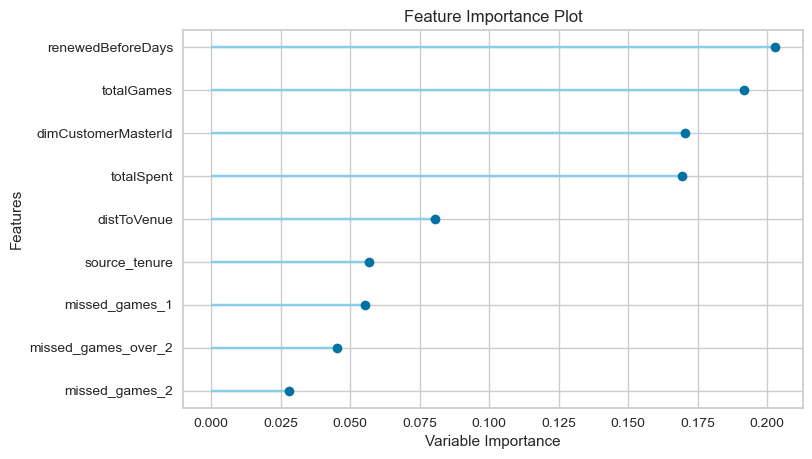

In [15]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?